In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import utils


from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


#### Get the CESM tseries files for nutrients and other vars

In [2]:
case = 'g.e22b05.G1850ECOIAF_JRA.TL319_g17.002'
IAF = 'IAF2'

In [3]:
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/mean' + IAF

In [4]:
variables = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf',
             'diaz_P_lim_surf','diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','spCaCO3',
             'CaCO3_PROD_zint','SiO2_PROD','POC_FLUX_100m','diatC', 
             'spC','diazC','ALK','PO4','NO3','SiO3','ALK','O2'] 

In [5]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)

    files = sorted(glob(f'{path}/mean_{IAF}_{v}.nc'))       

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22b05.G1850ECOIAF_JRA.TL319_g17.002
sp_Fe_lim_surf
sp_P_lim_surf
sp_N_lim_surf
diat_Fe_lim_surf
diat_P_lim_surf
diat_N_lim_surf
diat_SiO3_lim_surf
diaz_P_lim_surf
diaz_Fe_lim_surf
photoC_TOT_zint
photoC_sp_zint
photoC_diat_zint
photoC_diaz_zint
spCaCO3
CaCO3_PROD_zint
SiO2_PROD
POC_FLUX_100m
diatC
spC
diazC
ALK
PO4
NO3
SiO3
ALK
O2
CPU times: user 1.6 s, sys: 122 ms, total: 1.72 s
Wall time: 2.7 s


#### Get the World Ocean Atlas dataset that has been interpolated onto the POP grid

In [6]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc'

In [7]:
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [8]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
area_m=ds_woa.TAREA * 1e-4
ds_woa['z_t'] = ds.z_t
depths_m=ds_woa.z_t * 0.01
dz=ds_woa.dz
dz_m=ds_woa.dz * 0.01

#### Make difference arrays for the nutrients, O$_2$, and AOU

In [9]:
NO3_diff = ds.NO3 - ds_woa.NO3
PO4_diff = ds.PO4 - ds_woa.PO4
SiO3_diff = ds.SiO3 - ds_woa.SiO3
O2_diff = ds.O2 - ds_woa.O2

#### Set up region mask for major basins

In [10]:
grid_name = 'POP_gx1v7'
ds_regmasks = pop_tools.get_grid(grid_name)

In [11]:
pop_tools.list_region_masks(grid_name)

['lat-range-basin', 'Pacific-Indian-Atlantic']

In [12]:
region_masks = pop_tools.list_region_masks(grid_name)
region_mask='Pacific-Indian-Atlantic'
mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

In [13]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

#### -------------------------------------------------------------------------- end of setup

### Surface macronutrient maps

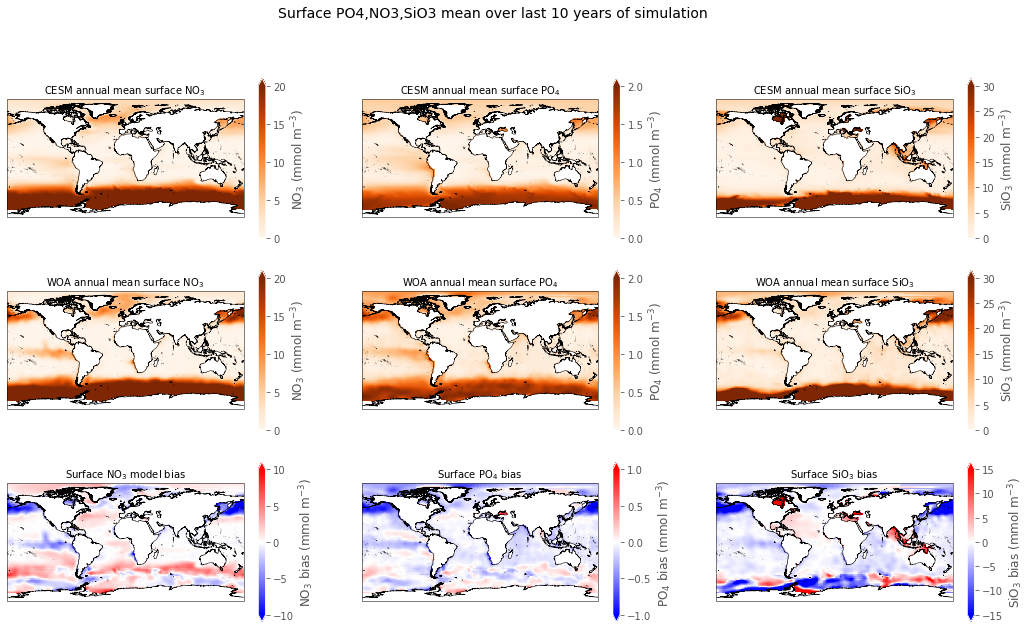

In [14]:
fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4,NO3,SiO3 mean over last 10 years of simulation', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface NO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface NO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=0), vmin=0, vmax=20, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface NO$_3$ model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff.isel(z_t=0), vmin=-10, vmax=10, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')



####################PO4
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface PO$_4$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface PO$_4$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=0), vmin=0, vmax=2, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='PO$_4$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface PO$_4$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff.isel(z_t=0), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



####################SiO3
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface SiO$_3$', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface SiO$_3$', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=0), 
                  vmin=0, vmax=30, 
                  cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='SiO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface SiO$_3$ bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff.isel(z_t=0), 
                  vmin=-15, vmax=15, 
                  cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')



### Thermocline macronutrient maps (~480m)

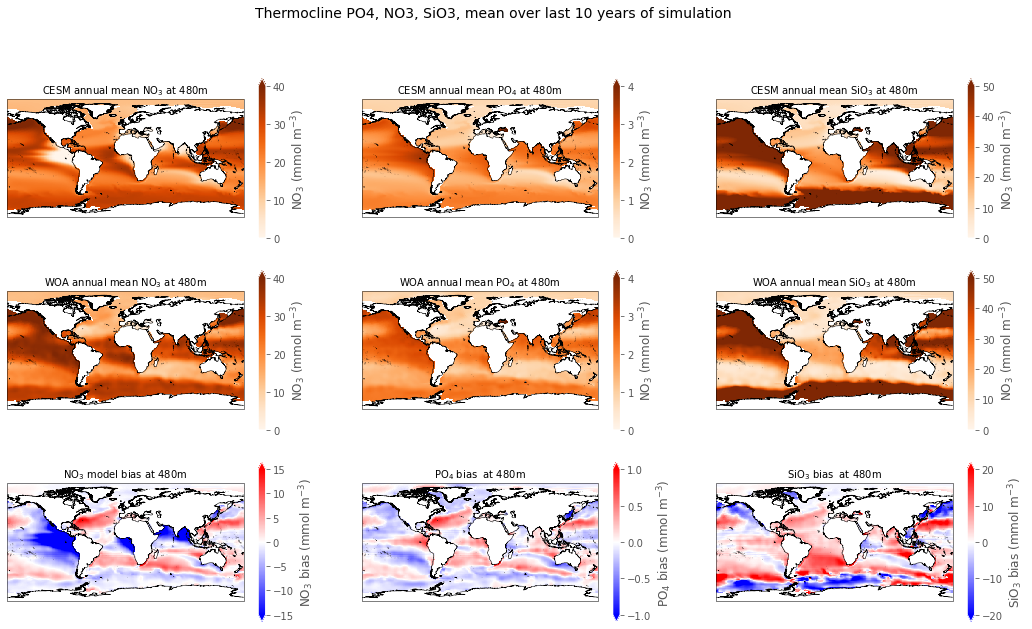

In [15]:
fig = plt.figure(figsize=(18,10))

plt.suptitle('Thermocline PO4, NO3, SiO3, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3######################

#---- CESM panel
ax = fig.add_subplot(3,3,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean NO$_3$ at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds.NO3.isel(z_t=32), vmin=0, vmax=40, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,4, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean NO$_3$ at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.NO3.isel(z_t=32), vmin=0, vmax=40, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,7, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('NO$_3$ model bias at 480m', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 NO3_diff.isel(z_t=32), vmin=-15, vmax=15, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')

#COLUMN 1  - PO4######################
#---- CESM panel
ax = fig.add_subplot(3,3,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean PO$_4$ at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds.PO4.isel(z_t=32), vmin=0, vmax=4, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,5, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean PO$_4$ at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.PO4.isel(z_t=32), vmin=0, vmax=4, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,8, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('PO$_4$ bias  at 480m', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 PO4_diff.isel(z_t=32), vmin=-1, vmax=1, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')



#COLUMN 3  - SiO3######################
#---- CESM panel
ax = fig.add_subplot(3,3,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean SiO$_3$ at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds.SiO3.isel(z_t=32), vmin=0, vmax=50, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,3,6, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean SiO$_3$ at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_woa.SiO3.isel(z_t=32), vmin=0, vmax=50, cmap='Oranges',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='NO$_3$ (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,3,9, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('SiO$_3$ bias  at 480m', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 SiO3_diff.isel(z_t=32), vmin=-20, vmax=20, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')

#### Global mean nutrient profiles

In [16]:
ds_glb = xr.Dataset({v: ds[v] for v in ['z_t']})
ds_glb['NO3']= esmlab.weighted_mean(ds['NO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['PO4']= esmlab.weighted_mean(ds['PO4'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['SiO3']= esmlab.weighted_mean(ds['SiO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb['O2']= esmlab.weighted_mean(ds['O2'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [17]:
ds_glb_woa = xr.Dataset({v: ds[v] for v in ['z_t']})
ds_glb_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['O2'] = esmlab.weighted_mean(ds_woa['O2'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU'], weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

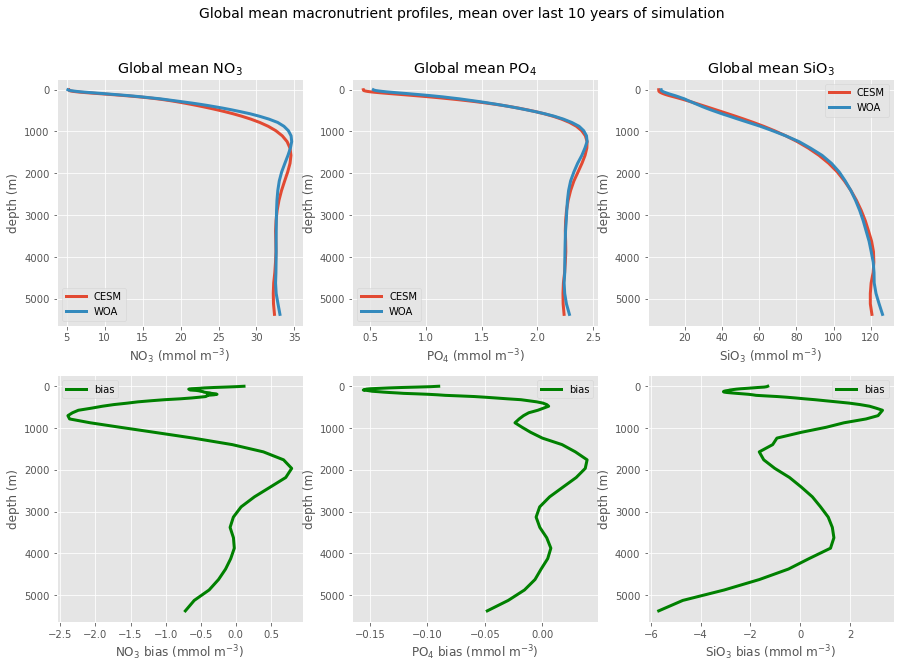

In [18]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds_glb['NO3'].values, depths_m, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['NO3'].values, depths_m, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds_glb['PO4'].values, depths_m, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['PO4'].values, depths_m, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds_glb['SiO3'].values, depths_m, label='CESM', linewidth=3)
ax.plot(ds_glb_woa['SiO3'].values, depths_m, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_glb['NO3'].values - ds_glb_woa['NO3'].values, depths_m, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_glb['PO4'].values - ds_glb_woa['PO4'].values, depths_m, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths_m, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



### Oxygen profile

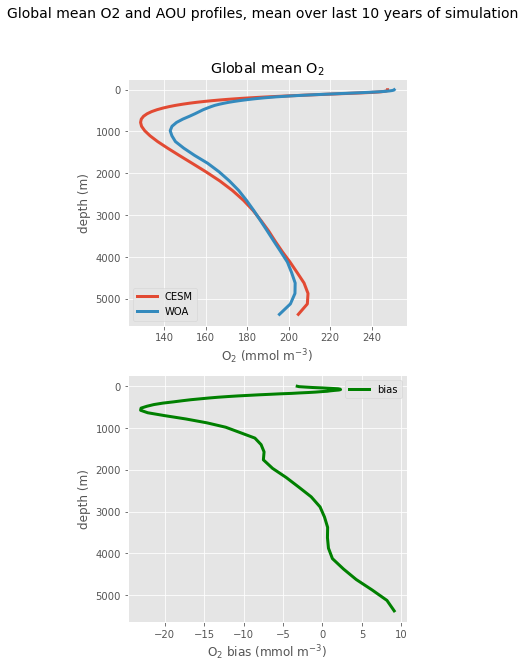

In [19]:
fig = plt.figure(figsize=(5,10))
plt.suptitle('Global mean O2 and AOU profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - O2

ax = fig.add_subplot(2,1,1)
ax.set_title('Global mean O$_2$')
ax.plot(ds_glb['O2'].values, depths_m, label='CESM',linewidth=3)
ax.plot(ds_glb_woa['O2'].values, depths_m, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - O2

ax = fig.add_subplot(2,1,2)
ax.plot(ds_glb['O2'].values - ds_glb_woa['O2'].values, depths_m, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



### Regional nutrient profiles

#### Pacific

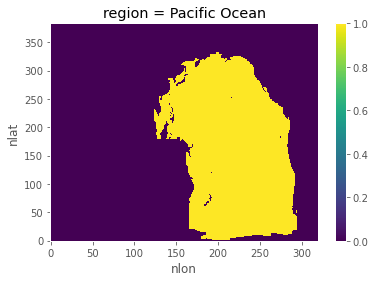

In [20]:
regnum=2
mask3d.isel(region=regnum).plot();

In [21]:
ds_pac = xr.Dataset()
ds_pac['NO3']= esmlab.weighted_mean(ds['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac['PO4']= esmlab.weighted_mean(ds['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac['SiO3']= esmlab.weighted_mean(ds['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac['O2']= esmlab.weighted_mean(ds['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()


In [22]:
ds_pac_woa = xr.Dataset()
ds_pac_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

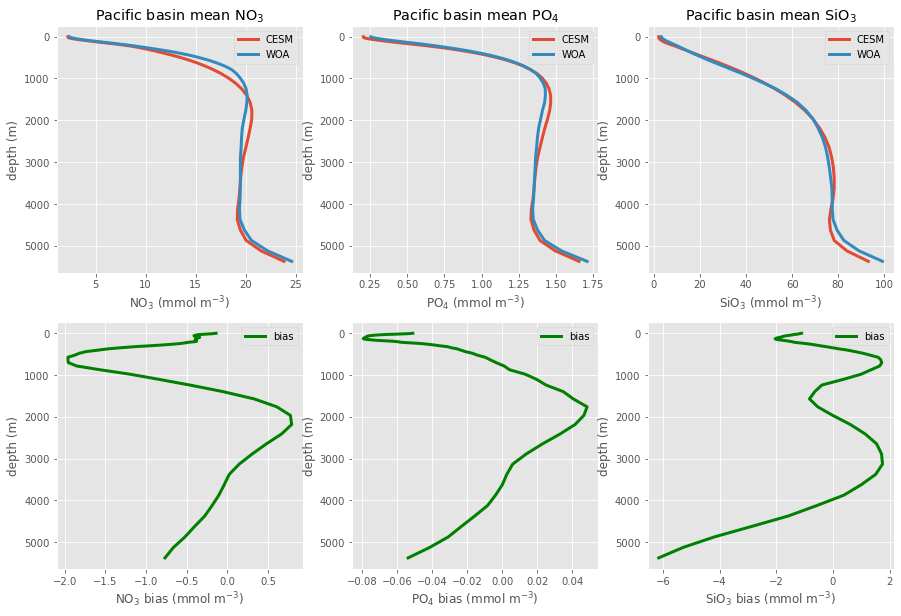

In [23]:
fig = plt.figure(figsize=(15,10))

#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Pacific basin mean NO$_3$')
ax.plot(ds_pac['NO3'].values, depths_m, label='CESM',linewidth=3)
ax.plot(ds_pac_woa['NO3'].values, depths_m, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Pacific basin mean PO$_4$')
ax.plot(ds_pac['PO4'].values, depths_m, label='CESM',linewidth=3)
ax.plot(ds_pac_woa['PO4'].values, depths_m, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Pacific basin mean SiO$_3$')
ax.plot(ds_pac['SiO3'].values, depths_m, label='CESM',linewidth=3)
ax.plot(ds_pac_woa['SiO3'].values, depths_m, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds_pac['NO3'].values - ds_pac_woa['NO3'].values, depths_m, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds_pac['PO4'].values - ds_pac_woa['PO4'].values, depths_m, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds_pac['SiO3'].values - ds_pac_woa['SiO3'].values, depths_m, label='bias', linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

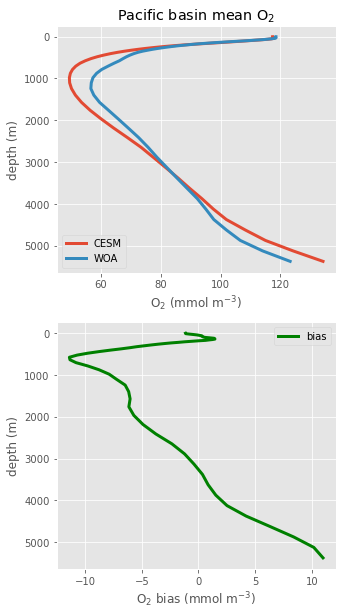

In [24]:
fig = plt.figure(figsize=(5,10))

#COLUMN 1  - O2

ax = fig.add_subplot(2,1,1)
ax.set_title('Pacific basin mean O$_2$')
ax.plot(ds_pac['O2'].values, depths_m, label='CESM',linewidth=3)
ax.plot(ds_pac_woa['O2'].values, depths_m, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



#COLUMN 1  - O2 bias

ax = fig.add_subplot(2,1,2)
ax.plot(ds_pac['O2'].values - ds_pac_woa['O2'].values, depths_m, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



#### Atlantic

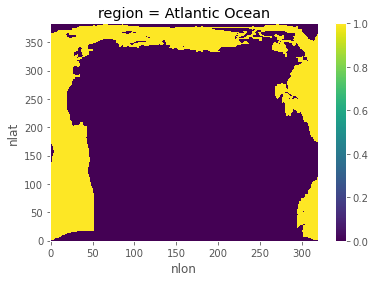

In [25]:
regnum=1
mask3d.isel(region=regnum).plot();

In [26]:
ds_atl = xr.Dataset()
ds_atl['NO3']= esmlab.weighted_mean(ds['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['PO4']= esmlab.weighted_mean(ds['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['SiO3']= esmlab.weighted_mean(ds['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl['O2']= esmlab.weighted_mean(ds['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

In [27]:
ds_atl_woa = xr.Dataset()
ds_atl_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds.TAREA, dim=['nlat', 'nlon']).compute()

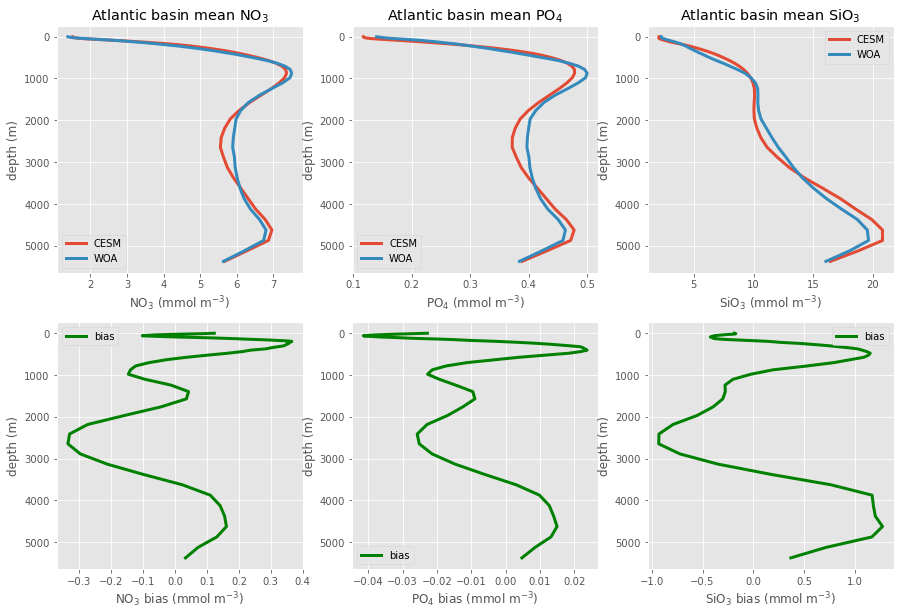

In [28]:
fig = plt.figure(figsize=(15,10))

#COLUMN 1  - NO3
ax = fig.add_subplot(2,3,1)
ax.set_title('Atlantic basin mean NO$_3$')
ax.plot(ds_atl['NO3'].values, depths_m, label='CESM',linewidth=3)
ax.plot(ds_atl_woa['NO3'].values, depths_m, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4
ax = fig.add_subplot(2,3,2)
ax.set_title('Atlantic basin mean PO$_4$')
ax.plot(ds_atl['PO4'].values, depths_m, label='CESM',linewidth=3)
ax.plot(ds_atl_woa['PO4'].values, depths_m, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3
ax = fig.add_subplot(2,3,3)
ax.set_title('Atlantic basin mean SiO$_3$')
ax.plot(ds_atl['SiO3'].values, depths_m, label='CESM',linewidth=3)
ax.plot(ds_atl_woa['SiO3'].values, depths_m, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 bias
ax = fig.add_subplot(2,3,4)
ax.plot(ds_atl['NO3'].values - ds_atl_woa['NO3'].values, depths_m, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 bias
ax = fig.add_subplot(2,3,5)
ax.plot(ds_atl['PO4'].values - ds_atl_woa['PO4'].values, depths_m, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 bias
ax = fig.add_subplot(2,3,6)
ax.plot(ds_atl['SiO3'].values - ds_atl_woa['SiO3'].values, depths_m, label='bias',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

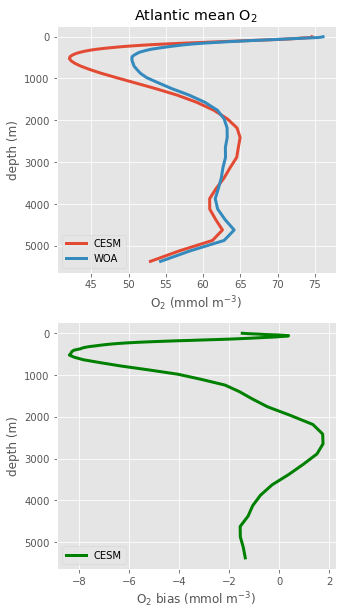

In [29]:
fig = plt.figure(figsize=(5,10))

#COLUMN 1  - O2
ax = fig.add_subplot(2,1,1)
ax.set_title('Atlantic mean O$_2$')
ax.plot(ds_atl['O2'].values, depths_m, label='CESM',linewidth=3)
ax.plot(ds_atl_woa['O2'].values, depths_m, label='WOA',linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 1  - O2 bias
ax = fig.add_subplot(2,1,2)
ax.plot(ds_atl['O2'].values - ds_atl_woa['O2'].values, depths_m, label='CESM',linewidth=3, color='green')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='O$_2$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


### Phytoplankton nutrient limitation at surface

In [30]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)

limarray_sp=xr.concat((ds.sp_P_lim_surf, ds.sp_Fe_lim_surf,ds.sp_N_lim_surf),dim='nutrient')
limarray_diat=xr.concat((ds.diat_P_lim_surf, ds.diat_Fe_lim_surf, ds.diat_N_lim_surf, ds.diat_SiO3_lim_surf),dim='nutrient')
limarray_diaz=xr.concat((ds.diaz_P_lim_surf, ds.diaz_Fe_lim_surf),dim='nutrient')

In [31]:
most_lim_sp=limarray_sp.argmin(dim='nutrient', skipna=False)
most_lim_diat=limarray_diat.argmin(dim='nutrient', skipna=False)
most_lim_diaz=limarray_diaz.argmin(dim='nutrient', skipna=False)
mask = np.isnan(ds.sp_N_lim_surf.squeeze())

In [32]:
most_lim_sp = most_lim_sp.squeeze()
most_lim_diat = most_lim_diat.squeeze()
most_lim_diaz = most_lim_diaz.squeeze()

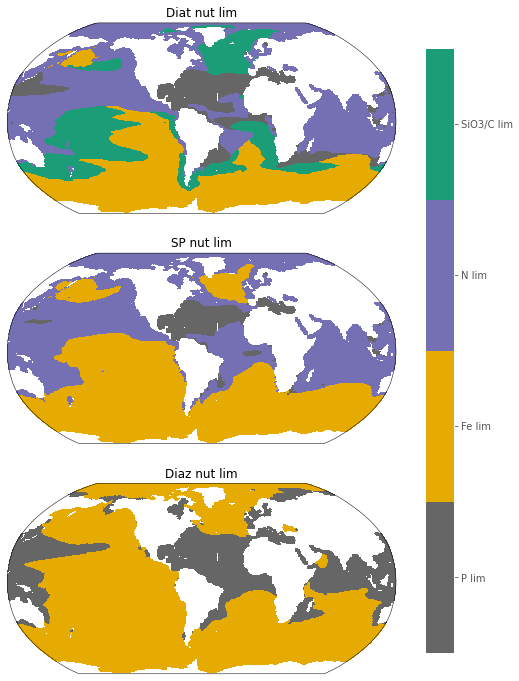

In [33]:
fig = plt.figure(figsize=(8,12))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diat nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diat.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('SP nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_sp.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diaz nut lim', fontsize=12)
pc=ax.pcolormesh(lons, lats, most_lim_diaz.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
colorbar_specs = {'ticks' : np.arange(0,4,1)}


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Look at phyto carbon pools

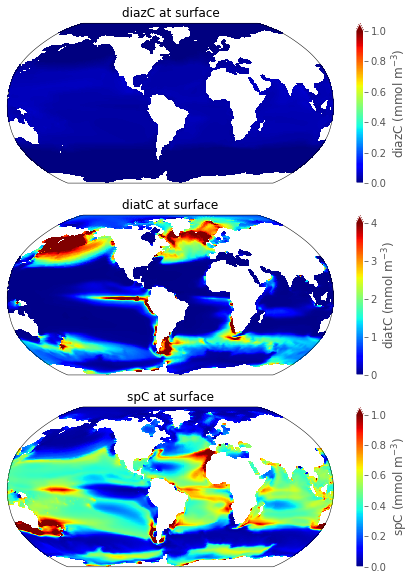

In [34]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds.diazC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds.diatC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds.spC.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')

### Look at percent phytoC

In [35]:
phytoC = ds.spC + ds.diatC + ds.diazC
perc_sp = ds.spC / (phytoC) * 100.
perc_diat = ds.diatC / (phytoC) * 100.
perc_diaz = ds.diazC / (phytoC) * 100.

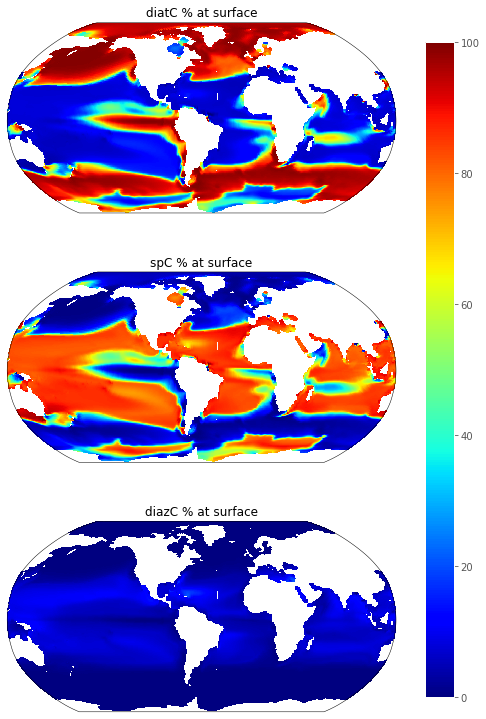

In [36]:
fig = plt.figure(figsize=(8,13))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_diat.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_sp.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC % at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, perc_diaz.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax)

### NPP

In [37]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'TOT']]

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:           ()
Data variables:
    photoC_diat_zint  float64 21.75
    photoC_sp_zint    float64 22.09
    photoC_diaz_zint  float64 1.587
    photoC_TOT_zint   float64 45.43

### Calcification

In [38]:
## GLOBALLY integrated calcification; observation-based estimates range from 0.8 to 2.4 Pg CaCO3 per year 
## (Feely et al., 2004, Maranon et al., 2016, Smith et al., 2016, Balch et al., 2007, Iglesias-Rodriguez et al., 2002)
ds_glb['CaCO3_PROD_zint'] = esmlab.statistics.weighted_sum(ds['CaCO3_PROD_zint'], weights=area, dim=['nlat', 'nlon'])
ds_glb['CaCO3_PROD_zint'] = ds_glb['CaCO3_PROD_zint'] * nmols_to_PgCyr
ds_glb['CaCO3_PROD_zint'].values
print('Globally integrated calcification is',ds_glb['CaCO3_PROD_zint'].values, 'Pg C per year')
print('(should be between 0.6 to 2.4 Pg C per year)')

Globally integrated calcification is 0.5934406077797311 Pg C per year
(should be between 0.6 to 2.4 Pg C per year)


In [39]:
#read in mean PIC
pic_file = '/glade/work/kristenk/satellite_data/processed/PIC_mean2003to2018_1deg.nc'
ds_pic=xr.open_dataset(pic_file, decode_times=False)
#ds_pic.PIC

In [40]:
#convert to mmol/m3 from mg/m3
ds_pic['PIC']=ds_pic.PIC / 12.011

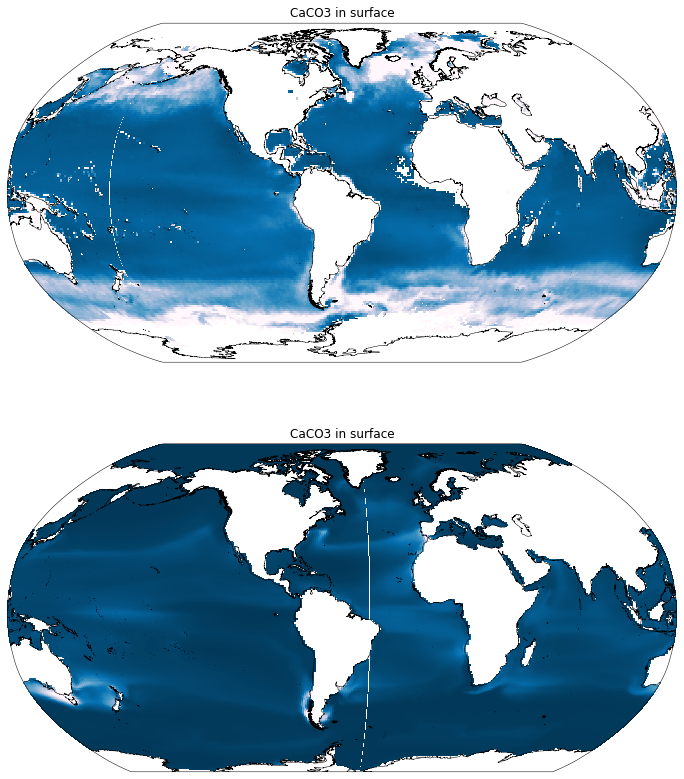

In [41]:
fig = plt.figure(figsize=(12,14))


ax = fig.add_subplot(2,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_pic.lon.values, ds_pic.lat.values, ds_pic.PIC, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())


ax = fig.add_subplot(2,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, ds.spCaCO3.isel(z_t_150m=0), cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())



### Alkalinity

In [42]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/GLODAPv2_regridded/glodap_pop_grid/GLODAP_POPgrid_v2.nc'
ds_glodap = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_glodap['z_t']=ds.z_t

In [43]:
ALK_diff = ds.ALK - ds_glodap.ALK

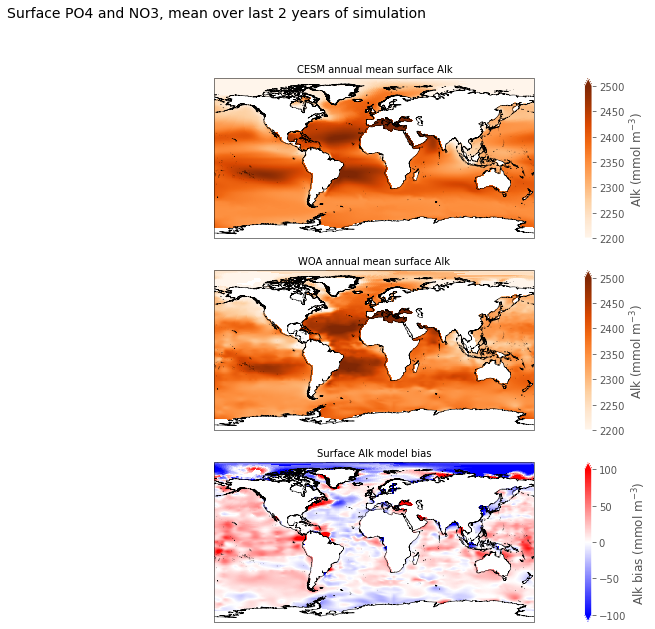

In [44]:
#plot surface alkalinity

fig = plt.figure(figsize=(18,10))
plt.suptitle('Surface PO4 and NO3, mean over last 2 years of simulation', fontsize=14)

####################NO3
#COLUMN 1  - NO3
#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM annual mean surface Alk', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds.ALK.isel(z_t=0), cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='Alk (mmol m$^{-3}$)')

#---- OBS panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('WOA annual mean surface Alk', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds_glodap.ALK.isel(z_t=0), cmap='Oranges',
                  vmin=2200, vmax=2500, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='max',label='Alk (mmol m$^{-3}$)')

#---- DIFF panel
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Surface Alk model bias', fontsize=10)
pc3=ax.pcolormesh(lons, lats, 
                 ALK_diff.isel(z_t=0), vmin=-100, vmax=100, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc3, ax=ax,extend='both',label='Alk bias (mmol m$^{-3}$)')

### POC flux

In [45]:
ds_glb['POC_FLUX_100m'] = esmlab.statistics.weighted_sum(ds['POC_FLUX_100m'], weights=area, dim=['nlat', 'nlon'])
ds_glb['POC_FLUX_100m'] = ds_glb['POC_FLUX_100m'] * nmols_to_PgCyr
ds_glb['POC_FLUX_100m'].values
print('Globally integrated POC flux is',ds_glb['POC_FLUX_100m'].values, 'Pg C per year')

Globally integrated POC flux is 7.08467660218688 Pg C per year


### Zonal mean nutrient biases

In [46]:
ds['NO3_diff']= NO3_diff
ds['PO4_diff']=PO4_diff
ds['SiO3_diff']=SiO3_diff
ds['O2_diff']=O2_diff

In [47]:
variables=['NO3_diff','PO4_diff','SiO3_diff','O2_diff']

In [48]:
rmask_file = os.path.join(os.path.sep,
                          'glade',
                          'p',
                          'cgd',
                          'oce',
                          'people',
                          'klindsay',
                          'oldcgdoce',
                          'REGION_MASK',
                          'new_REGION_MASK_gx1v6.nc')

da_zonal_mean = dict()
for var in variables:
    print('doing variable:', var)
    ds_tmp = utils.zonal_mean_via_fortran(ds, var, grid='gx1v7',rmask_file=rmask_file)
    da_zonal_mean[var] = ds_tmp[var].compute()

doing variable: NO3_diff
Wrote dataset to /glade/work/kristenk/n8cmwxa8.nc
za ran successfully, writing netcdf output
doing variable: PO4_diff
Wrote dataset to /glade/work/kristenk/qnb0dlpm.nc
za ran successfully, writing netcdf output
doing variable: SiO3_diff
Wrote dataset to /glade/work/kristenk/8t4fxmu3.nc
za ran successfully, writing netcdf output
doing variable: O2_diff
Wrote dataset to /glade/work/kristenk/gl2_gdof.nc
za ran successfully, writing netcdf output


In [49]:
glob_PO4_zonal_diff = da_zonal_mean['PO4_diff'].isel(basins=0)
glob_NO3_zonal_diff = da_zonal_mean['NO3_diff'].isel(basins=0)
glob_SiO3_zonal_diff = da_zonal_mean['SiO3_diff'].isel(basins=0)
glob_O2_zonal_diff = da_zonal_mean['O2_diff'].isel(basins=0)

In [50]:
pac_PO4_zonal_diff = da_zonal_mean['PO4_diff'].isel(basins=1)
pac_NO3_zonal_diff = da_zonal_mean['NO3_diff'].isel(basins=1)
pac_SiO3_zonal_diff = da_zonal_mean['SiO3_diff'].isel(basins=1)
pac_O2_zonal_diff = da_zonal_mean['O2_diff'].isel(basins=1)

In [51]:
atl_PO4_zonal_diff = da_zonal_mean['PO4_diff'].isel(basins=3)
atl_NO3_zonal_diff = da_zonal_mean['NO3_diff'].isel(basins=3)
atl_SiO3_zonal_diff = da_zonal_mean['SiO3_diff'].isel(basins=3)
atl_O2_zonal_diff = da_zonal_mean['O2_diff'].isel(basins=3)

In [52]:
ind_PO4_zonal_diff = da_zonal_mean['PO4_diff'].isel(basins=2)
ind_NO3_zonal_diff = da_zonal_mean['NO3_diff'].isel(basins=2)
ind_SiO3_zonal_diff = da_zonal_mean['SiO3_diff'].isel(basins=2)
ind_O2_zonal_diff = da_zonal_mean['O2_diff'].isel(basins=2)

In [53]:
lats = da_zonal_mean['PO4_diff'].lat_t.values
depths = da_zonal_mean['PO4_diff'].z_t.values * 0.01 * 0.001

In [54]:
style.use('default')

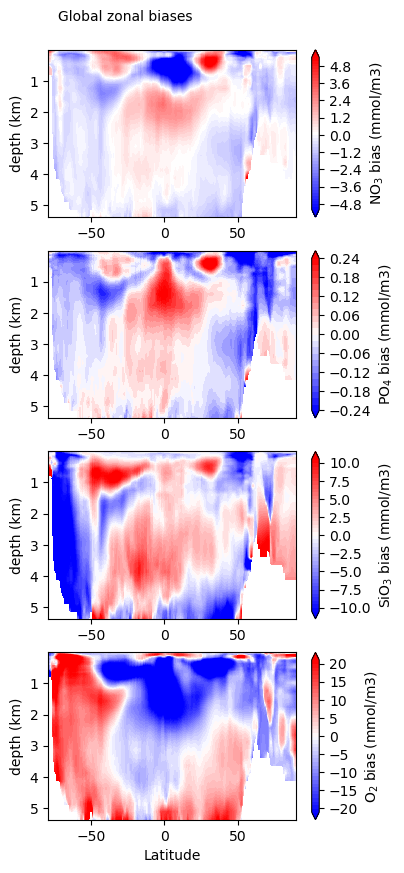

In [55]:
levels = np.arange(-0.24,0.26,0.02)

fig = plt.figure(figsize=(4,10))

plt.suptitle('Global zonal biases',x=0.15, y=0.92,fontsize=10,ha='left')

#NO3
ax = fig.add_subplot(4,1,1)
levels = np.arange(-5.2,5.4,0.2)
pc=ax.contourf(lats, depths, glob_NO3_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='NO$_3$ bias (mmol/m3)')

#PO4
ax = fig.add_subplot(4,1,2)
levels = np.arange(-0.24,0.26,0.02)
pc=ax.contourf(lats, depths, glob_PO4_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='PO$_4$ bias (mmol/m3)')

#SiO3
ax = fig.add_subplot(4,1,3)
levels = np.arange(-10.5,11,0.5)
pc=ax.contourf(lats, depths, glob_SiO3_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='SiO$_3$ bias (mmol/m3)')


#O2
ax = fig.add_subplot(4,1,4)
levels = np.arange(-21,22,1)
pc=ax.contourf(lats, depths, glob_O2_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)',xlabel='Latitude')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='O$_2$ bias (mmol/m3)')



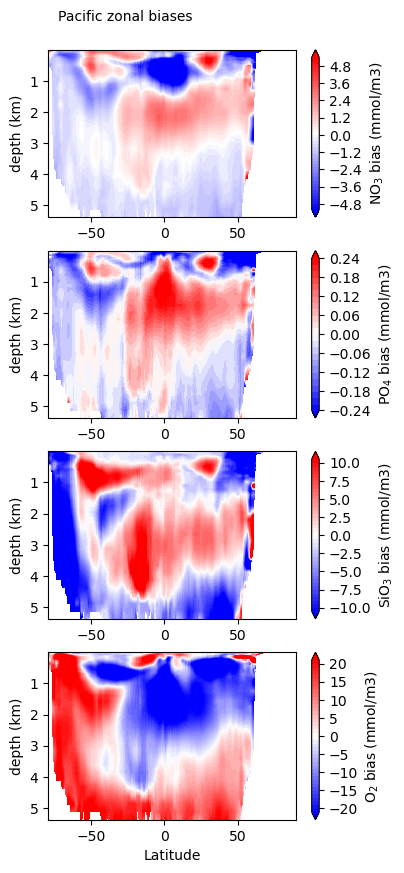

In [56]:
levels = np.arange(-0.24,0.26,0.02)

fig = plt.figure(figsize=(4,10))

plt.suptitle('Pacific zonal biases',x=0.15, y=0.92,fontsize=10,ha='left')

#NO3
ax = fig.add_subplot(4,1,1)
levels = np.arange(-5.2,5.4,0.2)
pc=ax.contourf(lats, depths, pac_NO3_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='NO$_3$ bias (mmol/m3)')

#PO4
ax = fig.add_subplot(4,1,2)
levels = np.arange(-0.24,0.26,0.02)
pc=ax.contourf(lats, depths, pac_PO4_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='PO$_4$ bias (mmol/m3)')

#SiO3
ax = fig.add_subplot(4,1,3)
levels = np.arange(-10.5,11,0.5)
pc=ax.contourf(lats, depths, pac_SiO3_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='SiO$_3$ bias (mmol/m3)')


#O2
ax = fig.add_subplot(4,1,4)
levels = np.arange(-21,22,1)
pc=ax.contourf(lats, depths, pac_O2_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)',xlabel='Latitude')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='O$_2$ bias (mmol/m3)')



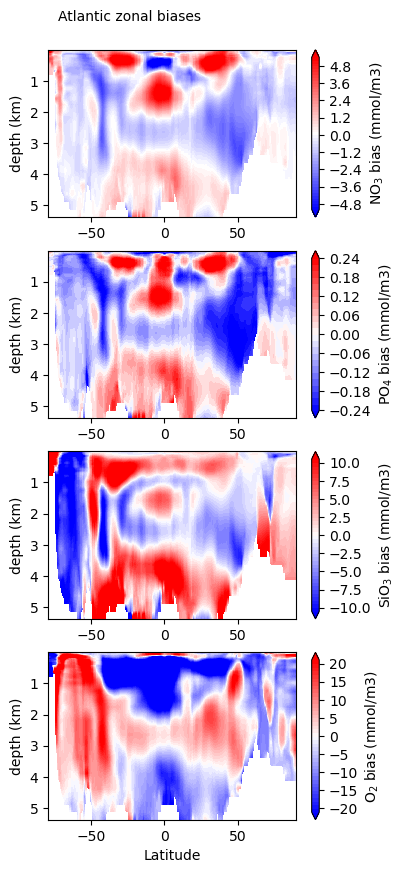

In [57]:
levels = np.arange(-0.24,0.26,0.02)

fig = plt.figure(figsize=(4,10))

plt.suptitle('Atlantic zonal biases',x=0.15, y=0.92,fontsize=10,ha='left')

#NO3
ax = fig.add_subplot(4,1,1)
levels = np.arange(-5.2,5.4,0.2)
pc=ax.contourf(lats, depths, atl_NO3_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='NO$_3$ bias (mmol/m3)')

#PO4
ax = fig.add_subplot(4,1,2)
levels = np.arange(-0.24,0.26,0.02)
pc=ax.contourf(lats, depths, atl_PO4_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='PO$_4$ bias (mmol/m3)')

#SiO3
ax = fig.add_subplot(4,1,3)
levels = np.arange(-10.5,11,0.5)
pc=ax.contourf(lats, depths, atl_SiO3_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='SiO$_3$ bias (mmol/m3)')


#O2
ax = fig.add_subplot(4,1,4)
levels = np.arange(-21,22,1)
pc=ax.contourf(lats, depths, atl_O2_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)',xlabel='Latitude')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='O$_2$ bias (mmol/m3)')



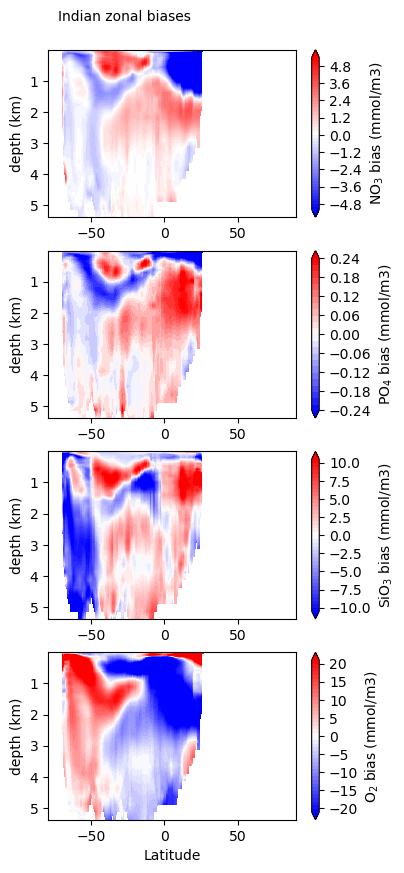

In [58]:
levels = np.arange(-0.24,0.26,0.02)

fig = plt.figure(figsize=(4,10))

plt.suptitle('Indian zonal biases',x=0.15, y=0.92,fontsize=10,ha='left')

#NO3
ax = fig.add_subplot(4,1,1)
levels = np.arange(-5.2,5.4,0.2)
pc=ax.contourf(lats, depths, ind_NO3_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='NO$_3$ bias (mmol/m3)')

#PO4
ax = fig.add_subplot(4,1,2)
levels = np.arange(-0.24,0.26,0.02)
pc=ax.contourf(lats, depths, ind_PO4_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='PO$_4$ bias (mmol/m3)')

#SiO3
ax = fig.add_subplot(4,1,3)
levels = np.arange(-10.5,11,0.5)
pc=ax.contourf(lats, depths, ind_SiO3_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='SiO$_3$ bias (mmol/m3)')


#O2
ax = fig.add_subplot(4,1,4)
levels = np.arange(-21,22,1)
pc=ax.contourf(lats, depths, ind_O2_zonal_diff, levels, cmap='bwr',extend='both')
ax.set(ylabel='depth (km)',xlabel='Latitude')
ax.invert_yaxis()
cbar = fig.colorbar(pc, label='O$_2$ bias (mmol/m3)')

